In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import ipaddress
from datetime import datetime

In [2]:
# stop warnings
import warnings 
warnings.filterwarnings('ignore')

In [62]:
sys.path.append('../scripts')

In [4]:
# Load the datasets
fraud_data = pd.read_csv('../data/Fraud_Data.csv')
ip_country_data = pd.read_csv('../data/IpAddress_to_Country.csv')
credit_card_data = pd.read_csv('../data/creditcard.csv')

In [5]:
# Check for missing values
print("Missing values in Fraud_Data.csv: ", fraud_data.isnull().sum())
print("Missing values in IpAddress_to_Country.csv: ", ip_country_data.isnull().sum())
print("Missing values in creditcard.csv: ", credit_card_data.isnull().sum())

Missing values in Fraud_Data.csv:  user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
Missing values in IpAddress_to_Country.csv:  lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64
Missing values in creditcard.csv:  Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [6]:
# Remove duplicates
fraud_data = fraud_data.drop_duplicates()
ip_address_to_country = ip_country_data.drop_duplicates()
creditcard_data = credit_card_data.drop_duplicates()

In [7]:
# Data Cleaning
def clean_data(df): 
    # Correct data types
    df['purchase_time'] = pd.to_datetime(df['purchase_time'])
    df['signup_time'] = pd.to_datetime(df['signup_time'])
    
    return df

fraud_data = clean_data(fraud_data)

In [8]:
print(fraud_data.dtypes)

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object


###  Exploratory Data Analysis

In [9]:
# Univariate analysis
print(fraud_data.describe())
print(ip_address_to_country.describe())
print(creditcard_data.describe())

             user_id                    signup_time  \
count  151112.000000                         151112   
mean   200171.040970  2015-04-20 00:56:09.511329280   
min         2.000000            2015-01-01 00:00:42   
25%    100642.500000     2015-02-18 09:52:48.500000   
50%    199958.000000            2015-04-19 04:41:30   
75%    300054.000000  2015-06-18 14:47:22.750000128   
max    400000.000000            2015-08-18 04:40:29   
std    115369.285024                            NaN   

                       purchase_time  purchase_value            age  \
count                         151112   151112.000000  151112.000000   
mean   2015-06-16 02:56:38.759952896       36.935372      33.140704   
min              2015-01-01 00:00:44        9.000000      18.000000   
25%       2015-04-18 14:41:25.500000       22.000000      27.000000   
50%       2015-06-18 13:46:17.500000       35.000000      33.000000   
75%       2015-08-17 18:48:31.500000       49.000000      39.000000   
max    

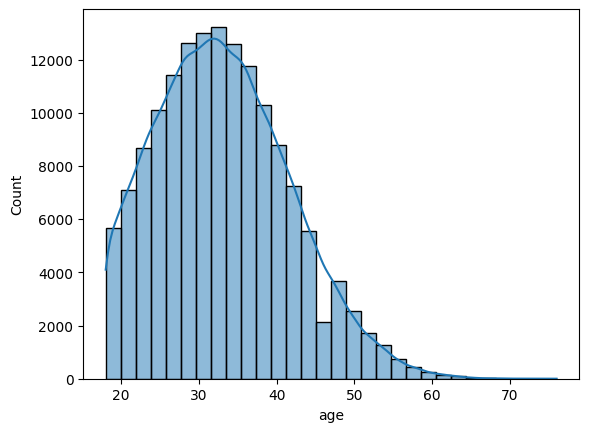

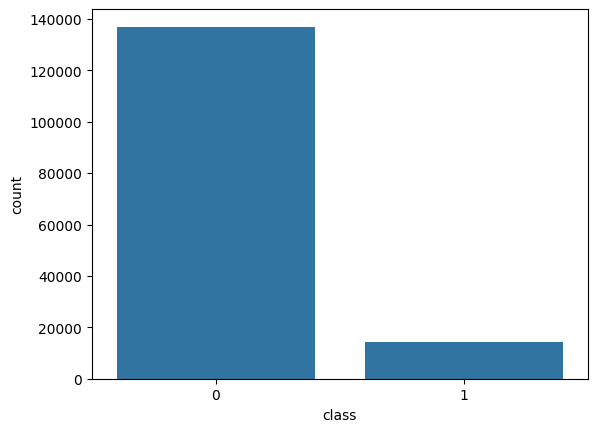

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Age distribution
sns.histplot(fraud_data['age'], bins=30, kde=True)
plt.show()

# Fraud distribution
sns.countplot(x='class', data=fraud_data)
plt.show()


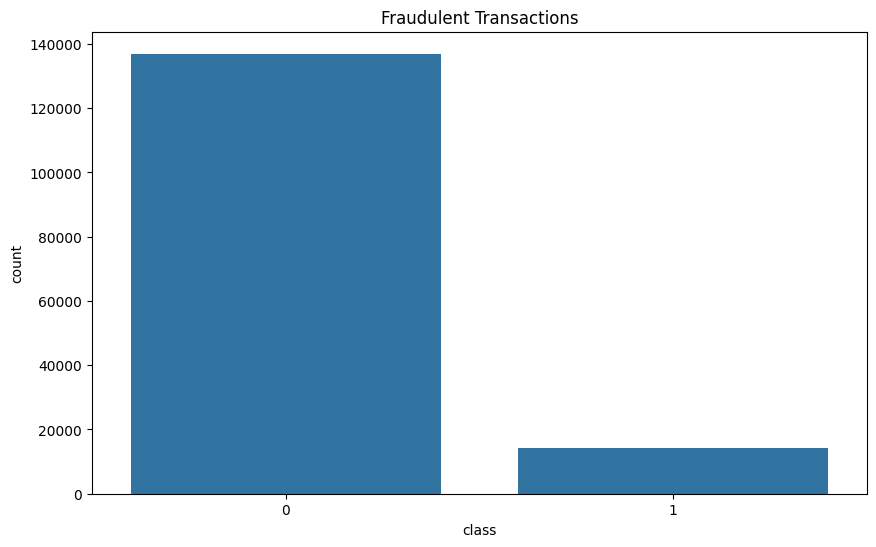

In [11]:
# Bivariate analysis
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=fraud_data)
plt.title('Fraudulent Transactions')
plt.show()

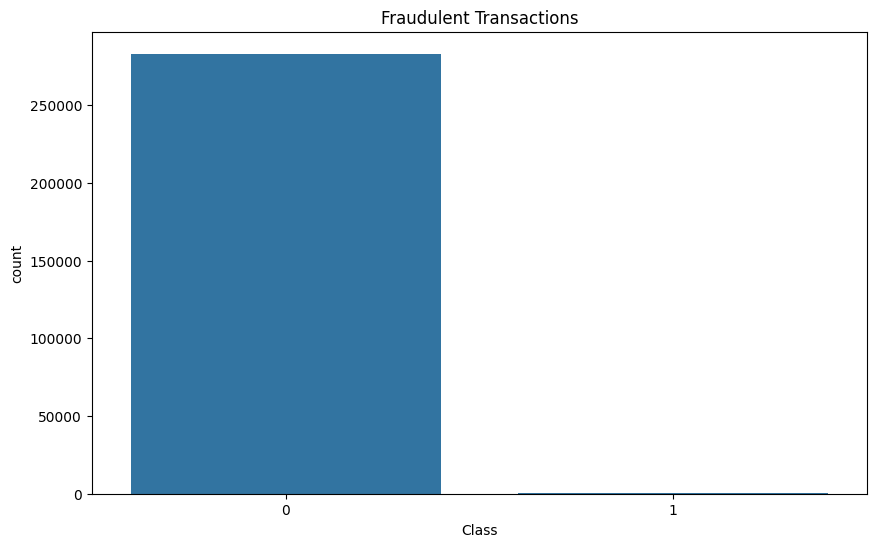

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=creditcard_data)
plt.title('Fraudulent Transactions')
plt.show()

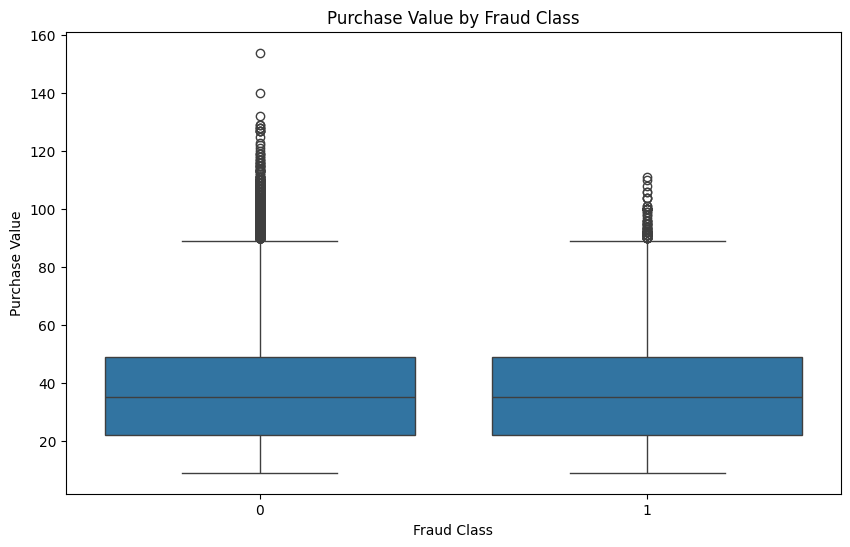

In [13]:
# Bivariate analysis: purchase_value vs class
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='purchase_value', data=fraud_data)
plt.title('Purchase Value by Fraud Class')
plt.xlabel('Fraud Class')
plt.ylabel('Purchase Value')
plt.show()

In [14]:
# Identify outliers in purchase_value
outliers = fraud_data[(fraud_data['class'] == 1) & (fraud_data['purchase_value'] > fraud_data['purchase_value'].quantile(0.75) + 1.5 * (fraud_data['purchase_value'].quantile(0.75) - fraud_data['purchase_value'].quantile(0.25)))]

# Display outliers
print(outliers[['user_id', 'purchase_value', 'device_id', 'source', 'browser']])


        user_id  purchase_value      device_id source  browser
974      370848             101  MWJEDXQTARYHR    SEO       IE
1772     247662              94  WOGVQIQNQORCW    Ads    Opera
4292     253067              92  FOROSWWYAQVFI    SEO       IE
7687      49987              98  VTRGHNJIPHNLG    SEO   Chrome
8056     118104              92  TZSHXHDMKLRYJ    Ads  FireFox
...         ...             ...            ...    ...      ...
145379   145101              92  TZSHXHDMKLRYJ    Ads  FireFox
148432   192192              96  EQYVNEGOFLAWK    Ads   Chrome
150535   365551              93  YTXYRSFLMAGJM    SEO   Safari
150684   216414              91  XPSSLODFBMYCV    SEO       IE
151082   305464              90  TVYSUZLTILQQN    SEO       IE

[99 rows x 5 columns]


In [15]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = fraud_data['purchase_value'].quantile(0.25)
Q3 = fraud_data['purchase_value'].quantile(0.75)
IQR = Q3 - Q1

# Determine outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = fraud_data[(fraud_data['purchase_value'] < lower_bound) | (fraud_data['purchase_value'] > upper_bound)]
print(outliers[['user_id', 'purchase_value']])


        user_id  purchase_value
47       262864              91
351       50437             107
470      361782              90
661      223039              92
974      370848             101
...         ...             ...
150535   365551              93
150684   216414              91
150715    13743              90
151066   219307              93
151082   305464              90

[1067 rows x 2 columns]


In [16]:
# Cap outliers
fraud_data['purchase_value'] = np.where(fraud_data['purchase_value'] > upper_bound, upper_bound, fraud_data['purchase_value'])
fraud_data['purchase_value'] = np.where(fraud_data['purchase_value'] < lower_bound, lower_bound, fraud_data['purchase_value'])


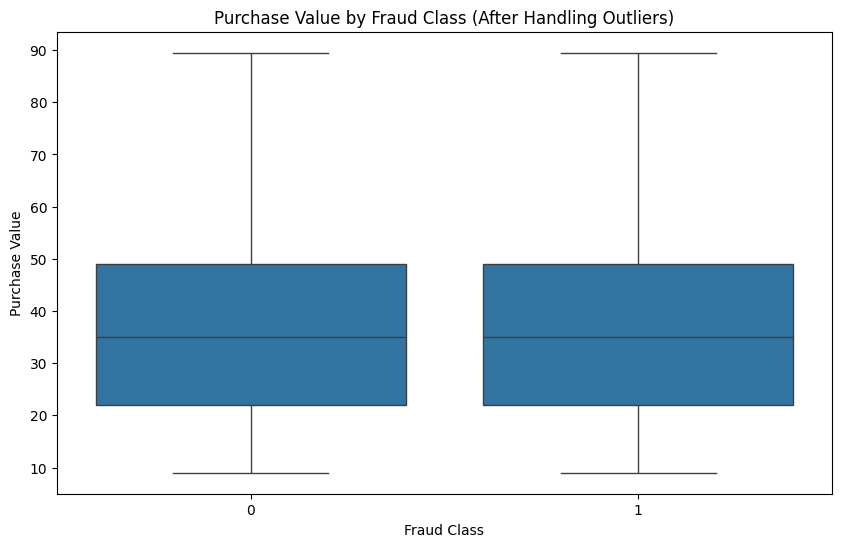

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='purchase_value', data=fraud_data)
plt.title('Purchase Value by Fraud Class (After Handling Outliers)')
plt.xlabel('Fraud Class')
plt.ylabel('Purchase Value')
plt.show()


In [18]:
import pandas as pd

# Load the datasets
fraud_data = pd.read_csv('../data/Fraud_Data.csv')
ip_to_country = pd.read_csv('../data/IpAddress_to_Country.csv')

# Display the first few rows of each dataset
print(fraud_data.head())
print(ip_to_country.head())


   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  
   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China


In [19]:
import pandas as pd

# Load the datasets
fraud_data = pd.read_csv('../data/Fraud_Data.csv')

# Check the data types
print(fraud_data.dtypes)

# Check for non-integer values
print(fraud_data['ip_address'].unique())

# Convert 'ip_address' to integer, handling NaN values
# Fill NaN with 0 (or you can choose to drop them if needed)
fraud_data['ip_address'] = pd.to_numeric(fraud_data['ip_address'], errors='coerce').fillna(0)

def float_to_int(float_ip):
    """Convert a float IP address to integer."""
    return int(float_ip)

# Convert the 'ip_address' column to integer
fraud_data['ip_address'] = fraud_data['ip_address'].apply(float_to_int)

# Display the first few rows to check the conversion
print(fraud_data[['user_id', 'ip_address']].head())

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object
[7.32758369e+08 3.50311388e+08 2.62147382e+09 ... 2.74847052e+09
 3.60117471e+09 4.10382451e+09]
   user_id  ip_address
0    22058   732758368
1   333320   350311387
2     1359  2621473820
3   150084  3840542443
4   221365   415583117


In [20]:
import pandas as pd

# Load the IpAddress_to_Country dataset
ip_country_data = pd.read_csv('../data/IpAddress_to_Country.csv')

# Check the data types of the loaded dataset
print(ip_country_data.dtypes)

# Check for non-integer values
print(ip_country_data['lower_bound_ip_address'].unique())
print(ip_country_data['upper_bound_ip_address'].unique())

# Convert 'lower_bound_ip_address' and 'upper_bound_ip_address' to integer, handling NaN values
# Fill NaN with 0 (or you can choose to drop them if needed)
ip_country_data['lower_bound_ip_address'] = pd.to_numeric(ip_country_data['lower_bound_ip_address'], errors='coerce').fillna(0).apply(lambda x: int(x))
ip_country_data['upper_bound_ip_address'] = pd.to_numeric(ip_country_data['upper_bound_ip_address'], errors='coerce').fillna(0).apply(lambda x: int(x))

# Function to find country based on IP address
def find_country(ip):
    ip_int = int(ip)  # Convert the IP address to its integer form
    # Check if the IP falls within any range
    for _, row in ip_country_data.iterrows():
        if row['lower_bound_ip_address'] <= ip_int <= row['upper_bound_ip_address']:
            return row['country']
    return "Country not found"

# Display the first few rows to verify the data
print(ip_country_data[['lower_bound_ip_address', 'upper_bound_ip_address', 'country']].head())

lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object
[1.67772160e+07 1.67774720e+07 1.67777280e+07 ... 3.75809536e+09
 3.75809587e+09 3.75809613e+09]
[  16777471   16777727   16778239 ... 3758095871 3758096127 3758096383]
   lower_bound_ip_address  upper_bound_ip_address    country
0                16777216                16777471  Australia
1                16777472                16777727      China
2                16777728                16778239      China
3                16778240                16779263  Australia
4                16779264                16781311      China


In [30]:
import pandas as pd

# Ensure 'lower_bound_ip_address' and 'upper_bound_ip_address' in ip_country_data are converted to integers
ip_country_data['lower_bound_ip_address'] = pd.to_numeric(ip_country_data['lower_bound_ip_address'], errors='coerce').fillna(0).astype(int)
ip_country_data['upper_bound_ip_address'] = pd.to_numeric(ip_country_data['upper_bound_ip_address'], errors='coerce').fillna(0).astype(int)

# Function to find the matching row from ip_country_data based on ip_address
def find_ip_info(ip):
    ip_int = int(ip)  # Convert the IP address to its integer form
    # Search for the country by checking the IP range
    country_row = ip_country_data[
        (ip_country_data['lower_bound_ip_address'] <= ip_int) & 
        (ip_country_data['upper_bound_ip_address'] >= ip_int)
    ]
    if not country_row.empty:
        return country_row.iloc[0][['country', 'lower_bound_ip_address', 'upper_bound_ip_address']]
    else:
        return pd.Series([None, None, None], index=['country', 'lower_bound_ip_address', 'upper_bound_ip_address'])

# Create a copy of fraud_data and apply the function to expand into new columns (country, lower_bound_ip_address, upper_bound_ip_address)
merged_data = fraud_data.copy()

# Apply the function to the 'ip_address' column
merged_data[['country', 'lower_bound_ip_address', 'upper_bound_ip_address']] = merged_data['ip_address'].apply(find_ip_info)

# Handle NaN values (optional step)
# If you want to fill NaN values with defaults, use fillna. You can customize this step based on your needs.
merged_data['lower_bound_ip_address'] = merged_data['lower_bound_ip_address'].fillna(0).astype(int)
merged_data['upper_bound_ip_address'] = merged_data['upper_bound_ip_address'].fillna(0).astype(int)

# Print the merged data with country and IP range information
print(merged_data)


        user_id          signup_time        purchase_time  purchase_value  \
0         22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1        333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2          1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3        150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4        221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   
...         ...                  ...                  ...             ...   
151107   345170  2015-01-27 03:03:34  2015-03-29 00:30:47              43   
151108   274471  2015-05-15 17:43:29  2015-05-26 12:24:39              35   
151109   368416  2015-03-03 23:07:31  2015-05-20 07:07:47              40   
151110   207709  2015-07-09 20:06:07  2015-09-07 09:34:46              46   
151111   138208  2015-06-10 07:02:20  2015-07-21 02:03:53              20   

            device_id  source browser sex  age  ip_address  class  \
0     

In [31]:
merged_data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,lower_bound_ip_address,upper_bound_ip_address
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan,729808896,734003199
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States,335544320,352321535
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,2621440000,2621505535
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,None,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,415498240,415629311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3451154526,1,United States,3451125760,3451387903
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2439047221,0,Netherlands,2436038656,2441084927
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2748470523,0,Japan,2748448768,2748514303
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3601174708,0,United States,3590324224,3607101439


In [32]:
# Checking for missing values in the merged data
missing_values = merged_data.isnull().sum()
missing_values


user_id                       0
signup_time                   0
purchase_time                 0
purchase_value                0
device_id                     0
source                        0
browser                       0
sex                           0
age                           0
ip_address                    0
class                         0
country                   21966
lower_bound_ip_address        0
upper_bound_ip_address        0
dtype: int64

In [33]:
# Calculate the percentage of missing values in each column of merged_data
missing_percentage = merged_data.isnull().mean() * 100

# Display the percentage of missing values
missing_percentage


user_id                    0.000000
signup_time                0.000000
purchase_time              0.000000
purchase_value             0.000000
device_id                  0.000000
source                     0.000000
browser                    0.000000
sex                        0.000000
age                        0.000000
ip_address                 0.000000
class                      0.000000
country                   14.536238
lower_bound_ip_address     0.000000
upper_bound_ip_address     0.000000
dtype: float64

In [34]:
# Fill missing values in the 'country' column with a default value
merged_data['country'].fillna('Unknown', inplace=True)

# Check the result
missing_values_percentage = merged_data.isnull().mean() * 100
print(missing_values_percentage)


user_id                   0.0
signup_time               0.0
purchase_time             0.0
purchase_value            0.0
device_id                 0.0
source                    0.0
browser                   0.0
sex                       0.0
age                       0.0
ip_address                0.0
class                     0.0
country                   0.0
lower_bound_ip_address    0.0
upper_bound_ip_address    0.0
dtype: float64


In [35]:
merged_data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,lower_bound_ip_address,upper_bound_ip_address
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan,729808896,734003199
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States,335544320,352321535
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,2621440000,2621505535
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,Unknown,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,415498240,415629311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3451154526,1,United States,3451125760,3451387903
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2439047221,0,Netherlands,2436038656,2441084927
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2748470523,0,Japan,2748448768,2748514303
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3601174708,0,United States,3590324224,3607101439


In [36]:
# Save the merged data after handling missing values
merged_data.to_csv('../data/merged_data.csv', index=False)

# Print the shape of the merged data to confirm saving
print("Merged data saved successfully with shape:", merged_data.shape)

Merged data saved successfully with shape: (151112, 14)


### Feature Engineering

In [4]:
import pandas as pd
from datetime import datetime


# Load the datasets
df = pd.read_csv('../data/merged_data.csv')

In [5]:
# Convert 'signup_time' and 'purchase_time' to datetime
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

# Sort the data by 'user_id' and 'purchase_time' to calculate velocity
df = df.sort_values(by=['user_id', 'purchase_time'])

# Calculate the transaction frequency for each user
transaction_frequency = df.groupby('user_id')['purchase_time'].count().reset_index()
transaction_frequency.columns = ['user_id', 'transaction_frequency']

# Merge transaction frequency back into the dataset
df = pd.merge(df, transaction_frequency, on='user_id', how='left')

# Calculate transaction velocity (time difference between consecutive transactions per user)
df['purchase_time_diff'] = df.groupby('user_id')['purchase_time'].diff().dt.total_seconds()

# Fill NaN values for the first transaction with 0 (no previous transaction to compare)
df['purchase_time_diff'].fillna(0, inplace=True)


C:\Users\amanu\AppData\Local\Temp\ipykernel_22124\1344139817.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['purchase_time_diff'].fillna(0, inplace=True)


In [6]:
# Extract hour of the day and day of the week from 'purchase_time'
df['hour_of_day'] = df['purchase_time'].dt.hour
df['day_of_week'] = df['purchase_time'].dt.dayofweek

In [8]:
# Save the updated DataFrame to a new CSV file
df.to_csv('../data/fraud_data_with_features.csv', index=False)

### Normalization and Scaling

In [9]:
import pandas as pd

# Define the path to the CSV file
file_path = '../data/fraud_data_with_features.csv'

# Load the CSV file into a DataFrame
fraud_data_with_features = pd.read_csv(file_path)

# Display the first few rows of the dataset
fraud_data_with_features.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,lower_bound_ip_address,upper_bound_ip_address,transaction_frequency,purchase_time_diff,hour_of_day,day_of_week
0,2,2015-01-11 03:47:13,2015-02-21 10:03:37,54,FGBQNDNBETFJJ,SEO,Chrome,F,25,880217484,0,United States,872415232,889192447,1,0.0,10,5
1,4,2015-06-02 16:40:57,2015-09-26 21:32:16,41,MKFUIVOHLJBYN,Direct,Safari,F,38,2785906106,0,Switzerland,2785542144,2786066431,1,0.0,21,5
2,8,2015-05-28 07:53:06,2015-08-13 11:53:07,47,SCQGQALXBUQZJ,SEO,Chrome,M,25,356056736,0,United States,352321536,369098751,1,0.0,11,3
3,9,2015-05-16 15:58:32,2015-05-20 23:06:42,62,IEZOHXPZBIRTE,SEO,FireFox,M,21,759104706,0,Unknown,0,0,1,0.0,23,2
4,12,2015-01-10 06:25:12,2015-03-04 20:56:37,35,MSNWCFEHKTIOY,Ads,Safari,M,19,2985180352,0,Mexico,2985033728,2985295871,1,0.0,20,2


In [10]:
fraud_data_with_features.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'lower_bound_ip_address', 'upper_bound_ip_address',
       'transaction_frequency', 'purchase_time_diff', 'hour_of_day',
       'day_of_week'],
      dtype='object')

In [11]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [13]:
# Check the scaled data
print(fraud_data_with_features[numerical_columns].describe())

             user_id  purchase_value            age    ip_address  \
count  151112.000000   151112.000000  151112.000000  1.511120e+05   
mean   200171.040970       36.935372      33.140704  2.152145e+09   
std    115369.285024       18.322762       8.617733  1.248497e+09   
min         2.000000        9.000000      18.000000  5.209300e+04   
25%    100642.500000       22.000000      27.000000  1.085934e+09   
50%    199958.000000       35.000000      33.000000  2.154770e+09   
75%    300054.000000       49.000000      39.000000  3.243258e+09   
max    400000.000000      154.000000      76.000000  4.294850e+09   

               class  lower_bound_ip_address  upper_bound_ip_address  \
count  151112.000000            1.511120e+05            1.511120e+05   
mean        0.093646            1.616077e+09            1.619236e+09   
std         0.291336            1.205680e+09            1.203963e+09   
min         0.000000            0.000000e+00            0.000000e+00   
25%         0.0000

### Encode Categorical Features

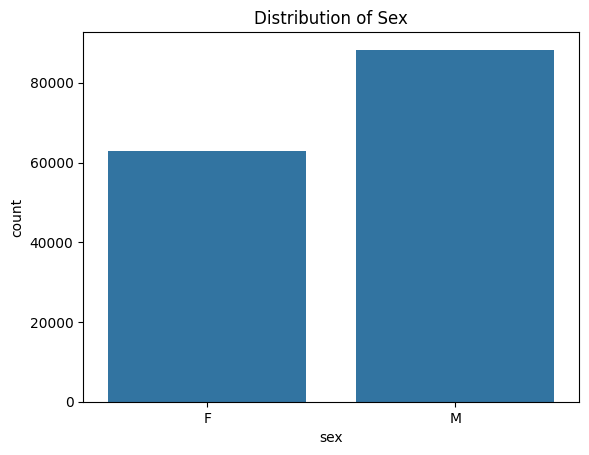

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example for visualizing the distribution of 'sex'
sns.countplot(data=df, x='sex')
plt.title('Distribution of Sex')
plt.show()


In [15]:
print(categorical_columns)

Index(['device_id', 'source', 'browser', 'sex', 'country'], dtype='object')


In [18]:
from sklearn.preprocessing import LabelEncoder

# Apply label encoding to categorical columns
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Now df contains label encoded values instead of one-hot encoded
print(df.head())


    user_id         signup_time       purchase_time  purchase_value  \
0 -1.735035 2015-01-11 03:47:13 2015-02-21 10:03:37        0.931338   
1 -1.735017 2015-06-02 16:40:57 2015-09-26 21:32:16        0.221836   
2 -1.734983 2015-05-28 07:53:06 2015-08-13 11:53:07        0.549298   
3 -1.734974 2015-05-16 15:58:32 2015-05-20 23:06:42        1.367955   
4 -1.734948 2015-01-10 06:25:12 2015-03-04 20:56:37       -0.105627   

   device_id  source  browser  sex       age  ip_address     class  country  \
0      27684       2        0    0 -0.944649   -1.018771 -0.321436      171   
1      65372       1        4    0  0.563874    0.507621 -0.321436      157   
2      96071       2        0    1 -0.944649   -1.438605 -0.321436      171   
3      43174       2        1    1 -1.408809   -1.115778 -0.321436      172   
4      67065       0        4    1 -1.640890    0.667232 -0.321436      107   

   lower_bound_ip_address  upper_bound_ip_address  transaction_frequency  \
0               -0.616

In [19]:
# Save the preprocessed data
df.to_csv('../data/fraud_data_preprocessed.csv', index=False)